In [1]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import datetime
import plotly.express as px
import joblib
import Funciones as fn

##**Conectar BD**

In [2]:
###### para ejecutar sql y conectarse a bd #####
conn=sql.connect('BD_insurance2019dataset')
cur=conn.cursor()

In [3]:
### para verificar las tablas que hay disponibles ###
pd.read_sql_query("SELECT * FROM sqlite_master; ",conn)

,type,name,tbl_name,rootpage,sql
0,table,reclamaciones,reclamaciones,2,CREATE TABLE reclamaciones (Reclamacion_Id INT...
1,table,diagnosticos,diagnosticos,3,CREATE TABLE diagnosticos (Diagnostico_Codigo ...
2,table,regional,regional,42,"CREATE TABLE regional (Regional_id INTEGER, Re..."
3,table,genero,genero,43,"CREATE TABLE genero (Sexo_Cd TEXT, Sexo_desc T..."
4,table,sociodemograficas,sociodemograficas,44,CREATE TABLE sociodemograficas (Afiliado_Id IN...
5,table,utilizaciones,utilizaciones,1328,CREATE TABLE utilizaciones (Fecha_Reclamacion ...


**Cargar Tablas**

In [4]:
utilizaciones = pd.read_sql("SELECT * FROM utilizaciones; ",conn)
sociodemograficas = pd.read_sql("SELECT * FROM sociodemograficas; ",conn)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218205 entries, 0 to 218204
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Afiliado_Id         218205 non-null  int64 
 1   Sexo_codigo         218205 non-null  object
 2   FechaNacimiento     218205 non-null  int64 
 3   Regional_codigo     218205 non-null  object
 4   CANCER              218205 non-null  int64 
 5   EPOC                218205 non-null  int64 
 6   DIABETES            218205 non-null  int64 
 7   HIPERTENSION        218205 non-null  int64 
 8   ENF_CARDIOVASCULAR  218205 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 15.0+ MB


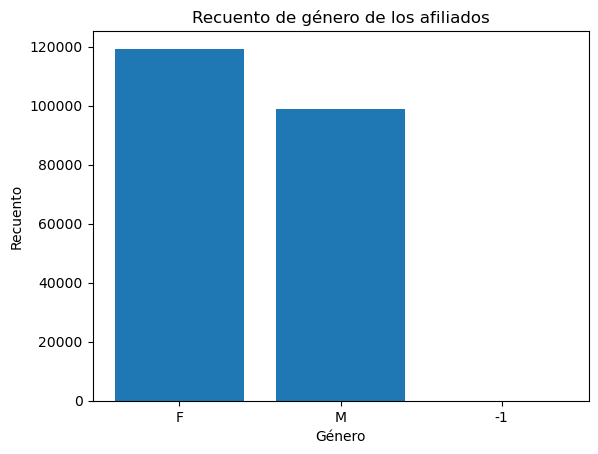

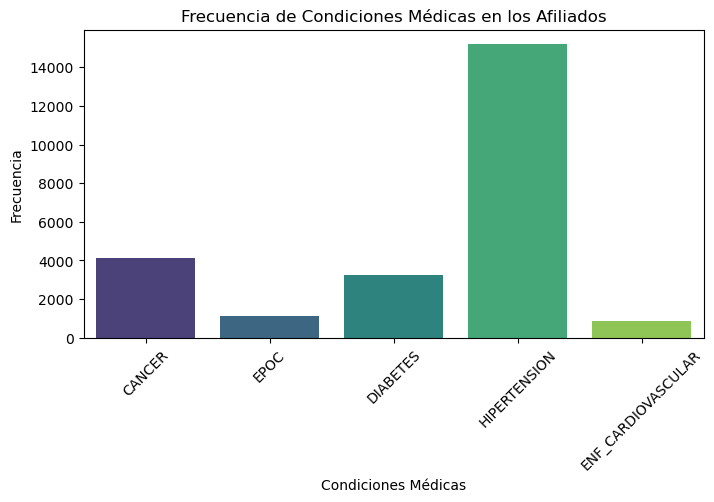

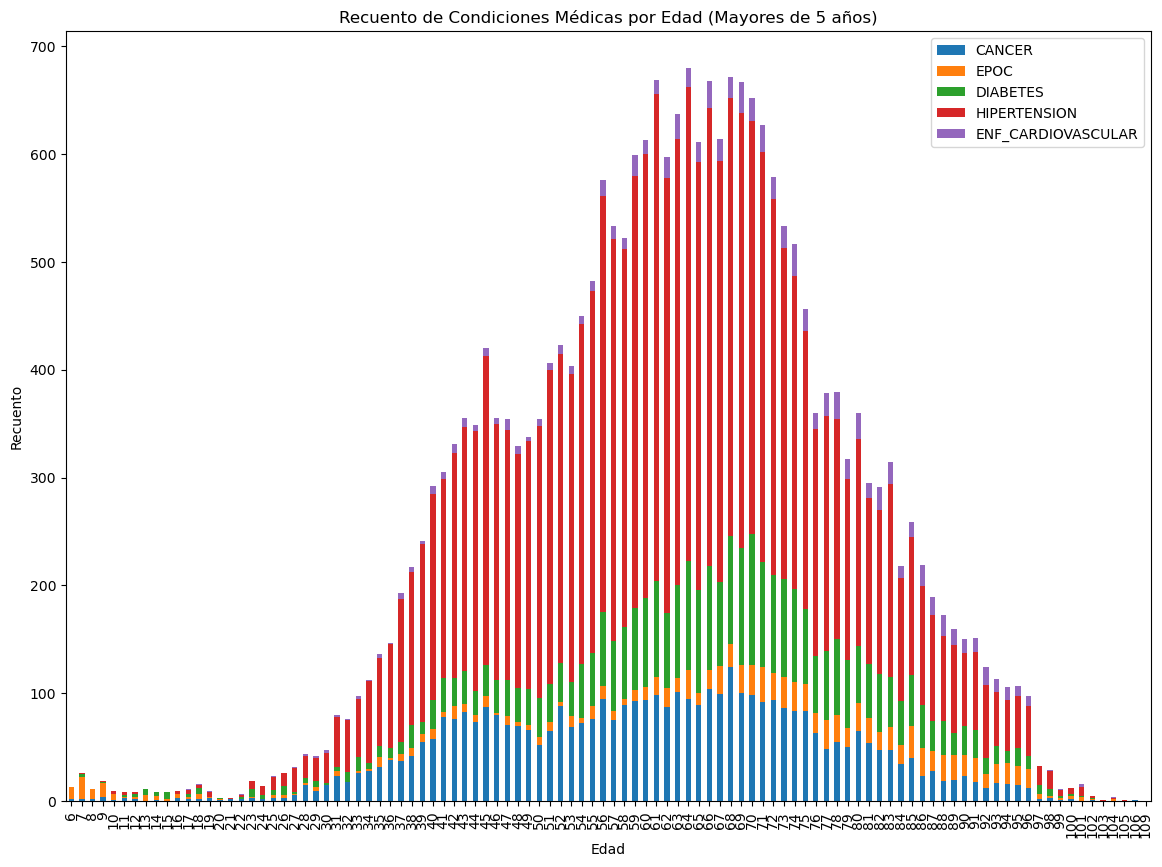

In [5]:
#### **Tabla Sociodemograficas**
sociodemograficas.info() # Se observa que tiene 2 campos, id de la región y descripción de cada región 
sociodemograficas.duplicated().sum() #No se tienen duplicados
sociodemograficas.head() # Es una tabla descriptiva de los valores asociados en otras tablas
sociodemograficas["Sexo_codigo"].value_counts()
sociodemograficas['FechaNacimiento'].min()
#En el sistema de numeración de fechas seriales de Excel, la fecha de serie base es el 1 de enero de 1900, representada por el número de serie 1.
# Aplicar la función lambda a la columna 'FechasExcel' y crear una nueva columna 'FechasConvertidas'
sociodemograficas['FechaNacimiento'] = sociodemograficas['FechaNacimiento'].apply(lambda x: datetime.datetime(1899, 12, 30) + datetime.timedelta(days=x))
top_5_fechas_recientes = sociodemograficas.nlargest(5, 'FechaNacimiento')['FechaNacimiento']
top_5_fechas_recientes #Hay que determinar que edad mínima, ya que hay muchas fechas recientes
sociodemograficas
sociodemograficas.columns
genero_counts = sociodemograficas['Sexo_codigo'].value_counts()

# Crear el gráfico de barras
plt.bar(genero_counts.index, genero_counts.values)

# Personalizar el gráfico
plt.xlabel('Género')
plt.ylabel('Recuento')
plt.title('Recuento de género de los afiliados')

# Mostrar el gráfico
plt.show()
# Seleccionar las columnas de las condiciones médicas con iloc
condiciones_cols = sociodemograficas.iloc[:, 4:]

# Calcular la frecuencia de las condiciones médicas
condiciones_counts = condiciones_cols.sum()

# Crear el gráfico de barras apiladas
plt.figure(figsize=(8, 4))
sns.barplot(x=condiciones_counts.index, y=condiciones_counts.values, palette='viridis')

# Personalizar el gráfico
plt.xlabel('Condiciones Médicas')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Condiciones Médicas en los Afiliados')
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()
# Calcular la edad a partir de la fecha de nacimiento
today = pd.to_datetime('today').date()
sociodemograficas['Edad'] = today.year - sociodemograficas['FechaNacimiento'].dt.year

# Filtrar el DataFrame para incluir solo las edades mayores de 5 años
df_filtrado = sociodemograficas[sociodemograficas['Edad'] > 5]

# Seleccionar las columnas de edad y condiciones médicas
condiciones = ['CANCER', 'EPOC', 'DIABETES', 'HIPERTENSION', 'ENF_CARDIOVASCULAR']
edad_condiciones = df_filtrado[['Edad'] + condiciones]

# Calcular el recuento de condiciones médicas por edad
conteo_condiciones = edad_condiciones.groupby('Edad')[condiciones].sum()

ax = conteo_condiciones.plot(kind='bar', stacked=True)

# Personalizar el gráfico
plt.xlabel('Edad')
plt.ylabel('Recuento')
plt.title('Recuento de Condiciones Médicas por Edad (Mayores de 5 años)')

# Ajustar el tamaño del gráfico manualmente
plt.gcf().set_size_inches(14, 10)

# Mostrar el gráfico
plt.show()
# Definir los rangos de edad y las etiquetas correspondientes
rangos = [0, 10, 20, 30, 40, 50, 60, 70, 80, float('inf')]
etiquetas = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80','81+']
# Agrupar las edades por rangos
sociodemograficas['Rango de edad'] = pd.cut(sociodemograficas['Edad'], bins=rangos, labels=etiquetas, right=False)
sociodemograficas=sociodemograficas[sociodemograficas['Rango de edad']!='0-10'] #Filtramos las edades de las personas que tienden a tener diabetes
sociodemograficas=sociodemograficas[sociodemograficas['Rango de edad']!='11-20']
sociodemograficas=sociodemograficas[sociodemograficas['Rango de edad']!='21-30']
sociodemograficas=sociodemograficas[sociodemograficas['Rango de edad']!='31-40']

In [6]:
sociodemograficas['Rango de edad'].unique()

['41-50', '51-60', '81+', '61-70', '71-80', NaN]
Categories (9, object): ['0-10' < '11-20' < '21-30' < '31-40' ... '51-60' < '61-70' < '71-80' < '81+']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395868 entries, 0 to 395867
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Fecha_Reclamacion   395868 non-null  object 
 1   Afiliado_Id         395868 non-null  int64  
 2   Reclamacion_codigo  395868 non-null  object 
 3   Diagnostico_Codigo  395868 non-null  object 
 4   Cantidad            395868 non-null  float64
 5   Precio              395868 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.1+ MB


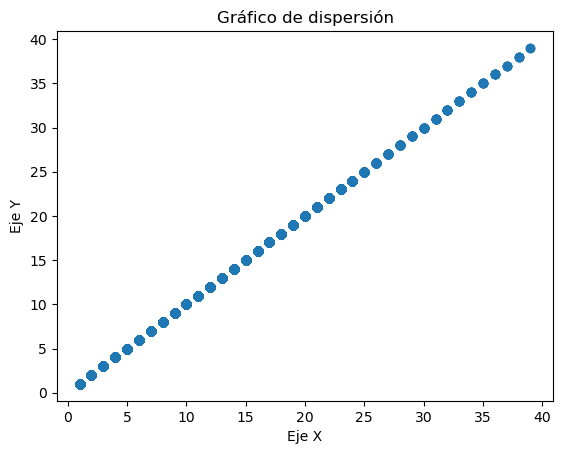

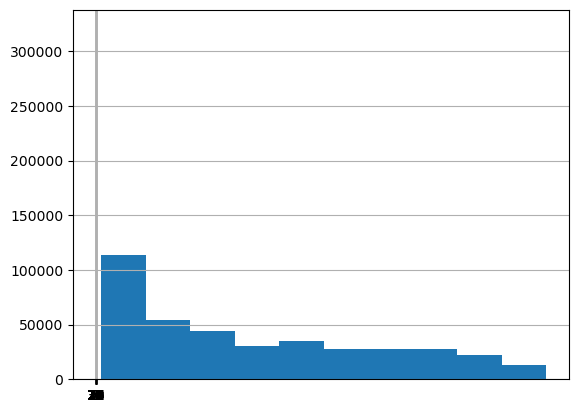

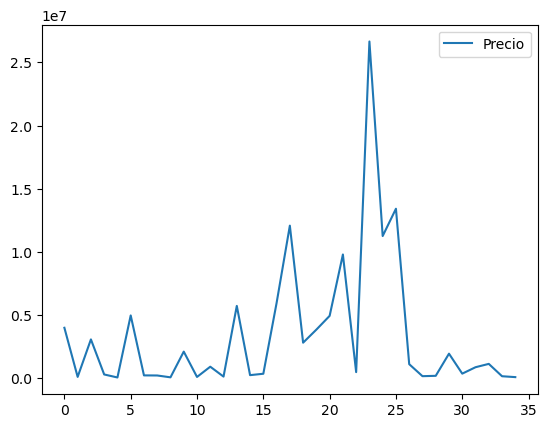

In [7]:
#### **Tabla Utilizaciones** 
utilizaciones.info() # Se observa que tiene 6 campos, Fecha_Reclamacion, Afiliado_Id, Reclamacion_codigo, Diagnostico_codigo, Cantidad, Precio

utilizaciones.duplicated().sum() #No se tienen duplicados

utilizaciones.head() # Es una tabla que contiene las reclamaciones realizadas
# Reemplazar los valores en Diagnostico_Codigo
utilizaciones["Diagnostico_Codigo"] = utilizaciones["Diagnostico_Codigo"].replace(["0", "9"], "-1")
utilizaciones.head()
# Reemplazar los valores en Cantidad
utilizaciones["Cantidad"] = utilizaciones["Cantidad"].replace(0,1).astype(int)
utilizaciones = utilizaciones[utilizaciones["Cantidad"] < 40]
import matplotlib.pyplot as plt
plt.scatter(utilizaciones["Cantidad"], utilizaciones["Cantidad"])
plt.title("Gráfico de dispersión")
plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.show()
utilizaciones["Precio Unit"] = utilizaciones["Precio"]/utilizaciones["Cantidad"]
utilizaciones['Fecha_Reclamacion']=pd.to_datetime(utilizaciones["Fecha_Reclamacion"], format='%d/%m/%Y')
utilizaciones['Afiliado_Id'].value_counts() 
utilizaciones['Afiliado_Id'].hist()
utilizaciones['Reclamacion_codigo'].value_counts() #El mayor número de reclamaciones realizadas son las de codigo 9
utilizaciones['Reclamacion_codigo'].hist(rwidth=0.6)
utilizaciones['Reclamacion_codigo'].min() #El codigo de menor reclamaciones realizada es el codigo 1
pd.set_option("display.max_rows", None) #Este codigo se utiliza para que value counts deje ver todos los resultados
utilizaciones['Reclamacion_codigo'].unique() #Existen 35 tipos de reclamaciones

utilizaciones['Diagnostico_Codigo'].value_counts() #El valor 9 no es un código de diagnostico, pero debido a la cantidad de datos que tiene, se toma como que hace referencia a sin diagnostico 
utilizaciones['Cantidad'].value_counts() #La mayor cantidad de reclamaciones correspondientes a los códigos. Se asume que el valor de 1 es para todos aquellos a los que no se les tiene registrado el diagnostico.
utilizaciones['Cantidad'].sort_values(ascending=False) #Las mayores cantidades de reclamaciones son 210
utilizaciones['Precio'].value_counts() #Estos valores son muy altos, se debn normalizar los datos
utilizaciones['Precio'].min() #El precio mínimo pagado es de 2.48 
utilizaciones['Precio'].max() #El precio máximo pagado es de 541,000,682.5
utilizaciones.columns
df=utilizaciones.groupby(['Reclamacion_codigo'])[['Precio']].mean().reset_index()
df.plot() #Los usuarios que mayor precio del seguro pagan son los que están entre los códigos 20 y 25. 
df=utilizaciones.groupby(['Diagnostico_Codigo'])[['Cantidad']].sum().reset_index() #El comportamiento de los clientes que si tuvieron un diagnositco


In [8]:
joblib.dump(utilizaciones,'utilizaciones.pkl')
joblib.dump(sociodemograficas,'sociodemograficas.pkl' )

['sociodemograficas.pkl']